In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import joblib

from bayes_opt import BayesianOptimization
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
##### Download of files.

print('Downloading datasets...')
print(' ')
df_train = pd.read_pickle('/kaggle/input/3-fraud-detection-preprocessing/train.pkl')
print('Train has been downloaded... (1/2)')
df_test = pd.read_pickle('/kaggle/input/3-fraud-detection-preprocessing/test.pkl')
print('Test has been downloaded... (2/2)')
print(' ')
print('All files are downloaded')

 
Train has been downloaded... (1/2)
Test has been downloaded... (2/2)
 
All files are downloaded


In [3]:
##### Feature selection for the model
# To prevent overfitting, we choose the elimination of some columns.

features = list(df_train)
features_to_remove = ['TransactionID','isFraud','TransactionDT','DT','uid1', 'uid2', 'uids', 'D1','D2','D4','D6','D10','D11','D12',
                     'D13','D14','D15']

for col in features_to_remove:
    features.remove(col)

# Get the feature list

print(f'Columns selected: {features}')
print(f'Lenght: {len(features)}')

Columns selected: ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D3', 'D5', 'D7', 'D8', 'D9', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95

In [4]:
##### Train + val separation
# We separate train (6 months) into train (4 months and 15 days) + skip (15 days) + val (1 month)

train = df_train.query('DT <= 135').copy()
val = df_train.query('DT >  150').copy()

In [5]:
##### Defining X and target

# Train
X_train = train[features]
y_train = train.isFraud
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

# Val
X_val = val[features]
y_val = val.isFraud
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)

# Test
X_test = df_test[features]
print('X_test:', X_test.shape)

X_train: (458800, 391)
y_train: (458800,)
X_val: (92427, 391)
y_val: (92427,)
X_test: (506691, 391)


# Modelling with LightGBM

In [6]:
##### Bayesian Optimization
# https://github.com/fmfn/BayesianOptimization

def objective(learning_rate,num_leaves,max_depth,colsample_bytree,subsample):
    
    # get X_train and X_val that are defined outside the functions that's why 'global' label
    global X_train
    global y_train
    global X_val
    global y_val
    
    # transform dtype of integers to avoid errors
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    
    # check dtype if not: stop and execute an error
    assert type(num_leaves) == int
    assert type(max_depth) == int
    
    # create the params
    parameters = {'objective': 'binary',
             'boosting_type': 'gbdt',
             'metric': 'auc',
             'n_jobs': -1,
             'tree_learner': 'serial',
             'learning_rate': learning_rate,
             'num_leaves': num_leaves,
             'max_depth': max_depth,
             'colsample_bytree': colsample_bytree,
             'subsample': subsample,
             'verbosity': -1,
             'random_state': 27}
    
    # create the dataset
    categorical_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9']
    
    train_data = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_columns)
    val_data = lgb.Dataset(X_val, label = y_val, categorical_feature = categorical_columns)
    
    # train the model
    model_lgb = lgb.train(parameters, train_data , valid_sets = [train_data, val_data], num_boost_round = 200, categorical_feature = categorical_columns,
                          early_stopping_rounds = 200, verbose_eval = 0)
    
    score  = roc_auc_score(y_val, model_lgb.predict(X_val))
                          
    return score

In [7]:
params = {'learning_rate': (0.02,0.03),
         'num_leaves': (225,275),
         'max_depth': (12,16),
         'colsample_bytree': (0.3,0.9),
         'subsample': (0.3,0.9)}

clf_BO = BayesianOptimization(objective, params, random_state = 27)

clf_BO.maximize(init_points = 3, n_iter = 20)

|   iter    |  target   | colsam... | learni... | max_depth | num_le... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.9224   |  0.5554   |  0.02815  |  14.94    |  268.4    |  0.53     |
|  2        |  0.924    |  0.8877   |  0.02893  |  12.84    |  262.1    |  0.6979   |
|  3        |  0.9252   |  0.8321   |  0.02858  |  15.0     |  268.5    |  0.4121   |
|  4        |  0.9265   |  0.714    |  0.02845  |  14.77    |  262.5    |  0.8654   |
|  5        |  0.9206   |  0.3982   |  0.02712  |  15.75    |  245.1    |  0.3969   |
|  6        |  0.9237   |  0.4995   |  0.02958  |  12.68    |  251.3    |  0.8831   |
|  7        |  0.9161   |  0.3058   |  0.02026  |  13.73    |  274.2    |  0.4251   |
|  8        |  0.9195   |  0.495    |  0.02615  |  12.93    |  253.1    |  0.79     |
|  9        |  0.9248   |  0.8726   |  0.02466  |  14.84    |  268.4    |  0.4097   |
|  10       |  0.9259   |  0.7571   |  0.02424  |  14.

In [8]:
print(f'Best Parameters: {clf_BO.max["params"]}')
print(' ')
print('Best AUC:',{clf_BO.max['target']})

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 14.227782876897928, 'num_leaves': 261.9698025597409, 'subsample': 0.9}
 
Best AUC: {0.92727011843538}


|     #     | learning_rate |    num_leaves   |    max_depth    |colsample_bytree |   subsample     |       AUC       |
|:----------:|:--------------:|:----------------:|:----------------:|:----------------:|:----------------:|----------------:|
| 1         |0.03215518473989215|             294 |             14 |             0.4 |             0.8 |0.9194457912401148|
| 2         |            0.04 |             278 |             13 |             0.4 |             0.9 |0.9164233793906151|
| 3         |0.027832622205538907|             268 |             15 |0.3740990054742914|0.589171882228726|0.9188929389573968|
| 4         |0.029827755272285032|             262 |             15 |0.7823490596970961|0.8631490082348747|0.92719808846762|

In [9]:
##### LightGBM with #3

parameters = {'objective': 'binary',
             'boosting_type': 'gbdt',
             'metric': 'auc',
             'n_jobs': -1,
             'tree_learner': 'serial',
             'learning_rate': 0.027832622205538907,
             'num_leaves': 268,
             'max_depth': 15,
             'colsample_bytree': 0.3740990054742914,
             'subsample': 0.589171882228726,
             'verbosity': -1,
             'random_state': 27}

categorical_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9']

train_data = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_columns)
val_data   = lgb.Dataset(X_val,   label = y_val, categorical_feature = categorical_columns)

clf = lgb.train(parameters, train_data , valid_sets = [train_data, val_data], num_boost_round = 200, categorical_feature = categorical_columns,
                          early_stopping_rounds = 200, verbose_eval = 100)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.966807	valid_1's auc: 0.910838
[200]	training's auc: 0.987707	valid_1's auc: 0.923519
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.987707	valid_1's auc: 0.923519


In [10]:
##### AUC

auc = roc_auc_score(y_val, clf.predict(X_val))
print('AUC:',auc)

AUC: 0.9235192329572796


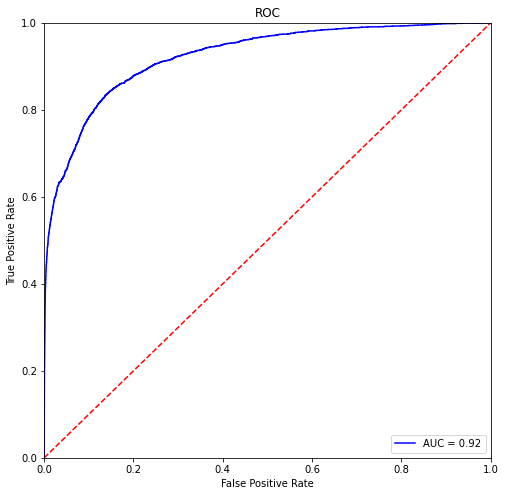

In [11]:
##### ROC Curve

y_pred = clf.predict(X_val)
r_curve = roc_curve(y_val, y_pred)

plt.figure(figsize=(8,8))
plt.title('ROC')
plt.plot(r_curve[0], r_curve[1], 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

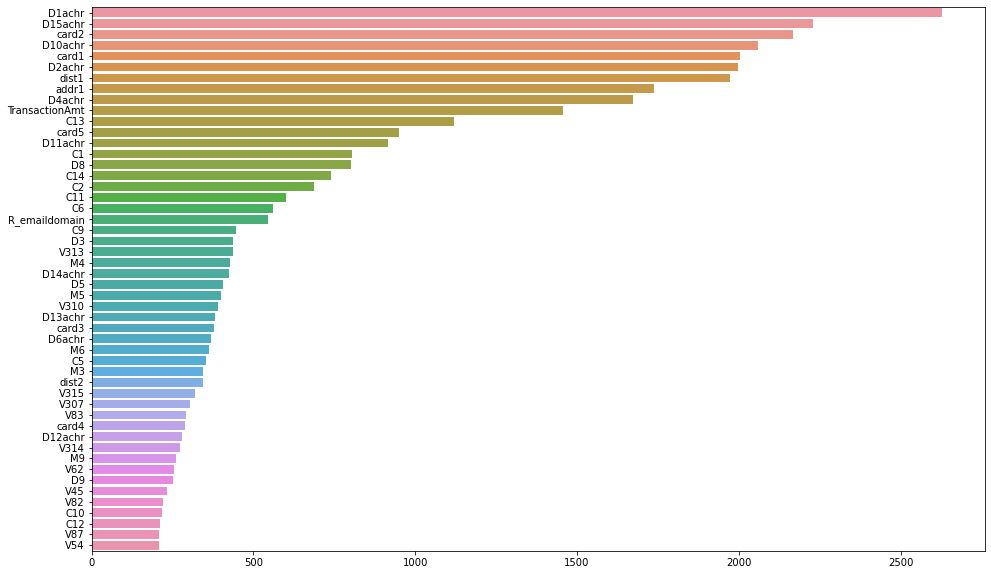

In [12]:
##### Feature Importance

features_importance = clf.feature_importance()
features_array = np.array(features)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y=features_array, x=features_importance, orient='h', order=features_array_ordered[:50])

plt.show()

In [13]:
##### Saving this results into an Excel file

try:
    model_results = pd.read_excel('model_results.xlsx')
    
    model_results = model_results.append({'datetime' : datetime.datetime.now(), 'clf':clf.__class__, 'features': features_array, 'parameters' : clf.params,
                                       'AUC': auc, 'features_importance': list(features_importance), 'features_ordered': list(features_array_ordered), 
                                       }, ignore_index = True)
        
except:
    model_results = pd.DataFrame(columns = ['summary', 'datetime', 'clf', 'features', 'parameters', 'entry1', 'entry2', 
                                            'AUC', 'features_importance', 'features_ordered', 'output1', 'output2'])
    
    model_results = model_results.append({'datetime' : datetime.datetime.now(), 'clf':clf.__class__, 'features': features_array, 'parameters' : clf.params, 
                                       'AUC': auc, 'features_importance': list(features_importance), 'features_ordered': list(features_array_ordered),
                                       }, ignore_index = True)
finally:
    model_results.to_excel('model_results.xlsx', index= False)

In [14]:
##### Saving this model

joblib.dump(clf, 'model_lightgbm.pkl')

['model_lightgbm.pkl']

# Submission to Kaggle

In [15]:
pred = clf.predict(X_test)
submission = pd.DataFrame()

submission['TransactionID'] = df_test['TransactionID']
submission['isFraud'] = pred

submission
submission.to_csv('submission.csv', index = False)

In [16]:
val.to_pickle('val_lgb.pkl')
print('Done!')

Done!
